In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from functions import constraints, objectives

2023-04-06 14:51:54.644293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_ONE = "EQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_TWO = "EQUALITY_CONSTRAINT_TWO"
EQUALITY_TOLERANCE = 0.01
INVALID_VAL = 2.1

In [3]:
def best_progression_over_time(path: str, num_runs: int):
    results = []
    for run in range(num_runs):
        with open(path + f"run_{run}_data.pkl", "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        equality_constraint_one_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()) <= EQUALITY_TOLERANCE
        equality_constraint_two_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()) <= EQUALITY_TOLERANCE
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, equality_constraint_one_satisfied)
        satisfied_mask = np.logical_and(satisfied_mask, equality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = INVALID_VAL
        results.append(np.minimum.accumulate(safe_obs_values))
    results = np.array(results)
    results_mean = np.mean(results, axis=0)
    return results, results_mean

In [17]:
GBSP_batch_one, GBSP_batch_one_mean = best_progression_over_time("GBSP_batch_one/", 20)
GBSP_batch_three, GBSP_batch_three_mean = best_progression_over_time("GBSP_batch_three/", 20)

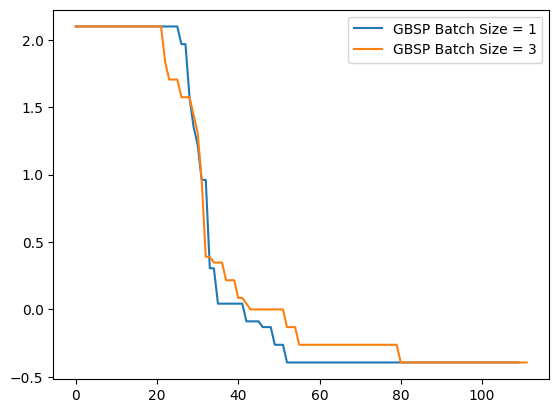

In [18]:
plt.plot(GBSP_batch_one_mean, label="GBSP Batch Size = 1")
plt.plot(GBSP_batch_three_mean, label="GBSP Batch Size = 3")
plt.legend()
plt.show()

In [73]:
GBSP_batch_one

array([[ 2.1       ,  2.1       ,  2.1       , ..., -0.52526823,
        -0.52526823, -0.52526823],
       [ 2.1       ,  2.1       ,  2.1       , ..., -0.52521513,
        -0.52521513, -0.52521513],
       [ 2.1       ,  2.1       ,  2.1       , ..., -0.52554919,
        -0.52554919, -0.52554919],
       ...,
       [ 2.1       ,  2.1       ,  2.1       , ...,  2.1       ,
         2.1       ,  2.1       ],
       [ 2.1       ,  2.1       ,  2.1       , ..., -0.52523931,
        -0.52523931, -0.52523931],
       [ 2.1       ,  2.1       ,  2.1       , ..., -0.52524961,
        -0.52524961, -0.52524961]])

**Stats:**
- For GBSP with BS = 3, 16/20 had reached the optimum within 43 iterations, only 1/20 never found the optimum.
- For GBSP with BS = 1, 16/20 had reached the optimum within 43 iterations, only 1/20 never found the optimum.

### Query Locations

In [76]:
# Run 17 converges to the wrong point
run = 17

with open(f"GBSP_batch_one/run_{run}_data.pkl", "rb") as fp:
    data = pickle.load(fp)

query_points = data[OBJECTIVE].query_points
observations = data[OBJECTIVE].observations

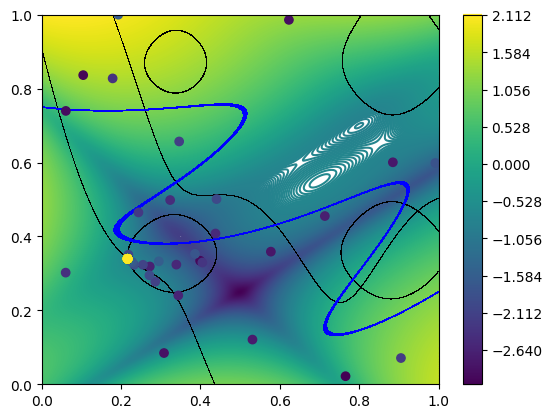

In [77]:
x_list = tf.linspace(0, 1, 500)
y_list = tf.linspace(0, 1, 500)
xs, ys = tf.meshgrid(x_list, y_list)
coordinates = tf.stack((tf.reshape(xs, [-1]), tf.reshape(ys, [-1])), axis=1)
goldstein_price_objective = objectives.goldstein_price(coordinates)
centered_branin_constraint = constraints.centered_branin(coordinates)
parr_constraint = constraints.parr_constraint(coordinates)
inequality_constraint = constraints.toy_constraint_one(coordinates)

fig, ax = plt.subplots()
objective_plot = ax.contour(xs, ys, tf.reshape(goldstein_price_objective, [y_list.shape[0], x_list.shape[0]]), levels=1000, zorder=1)
centered_branin_plot = ax.contourf(xs, ys, tf.reshape(centered_branin_constraint, [y_list.shape[0], x_list.shape[0]]), levels=[-0.01,0.01], zorder=1, colors='black')
parr_plot = ax.contourf(xs, ys, tf.reshape(parr_constraint, [y_list.shape[0], x_list.shape[0]]), levels=[-0.01,0.01], zorder=1, colors='black')
inequality_constraint_plot = ax.contourf(xs, ys, tf.reshape(inequality_constraint, [y_list.shape[0], x_list.shape[0]]), levels=[-0.01,0.01], zorder=1, colors='blue')
scatter_colours = tf.linspace(0, 1, len(query_points))
plt.scatter(query_points[:, 0], query_points[:, 1], c=scatter_colours, cmap='viridis')
fig.colorbar(objective_plot)
plt.show()

### Lagrange Multipliers (Batch Size = 1)

In [4]:
def get_lambda_progression(path: str, constraint: str):
    with open(path, "rb") as fp:
        penalty_progression = pickle.load(fp)[constraint]
        penalty_progression = np.array(penalty_progression).squeeze()
    return penalty_progression

In [64]:
run = 10
inequality_file_path = f"GBSP_batch_one/run_{run}_inequality_lambda_progression.pkl"
equality_file_path = f"GBSP_batch_one/run_{run}_equality_lambda_progression.pkl"
inequality_lambda_progression = get_lambda_progression(inequality_file_path, INEQUALITY_CONSTRAINT_ONE)
centered_branin_lambda_progression = get_lambda_progression(equality_file_path, EQUALITY_CONSTRAINT_ONE)
parr_lambda_progression = get_lambda_progression(equality_file_path, EQUALITY_CONSTRAINT_TWO)

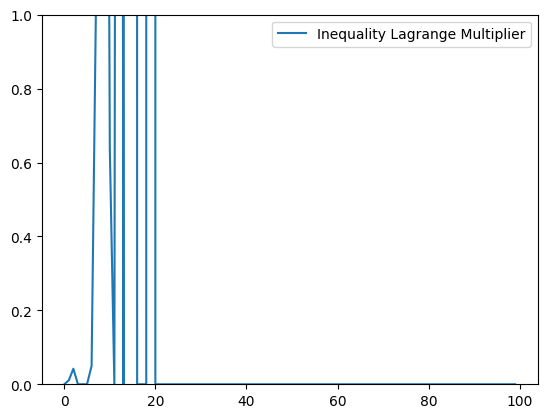

In [65]:
plt.plot(inequality_lambda_progression, label="Inequality Lagrange Multiplier")
plt.legend()
plt.ylim(0, 1)
plt.show()

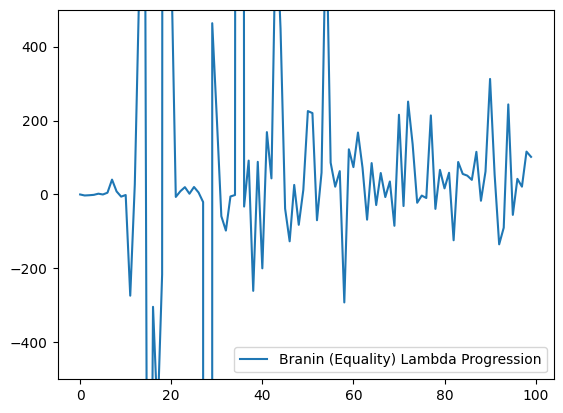

In [66]:
plt.plot(centered_branin_lambda_progression, label="Branin (Equality) Lambda Progression")
plt.legend()
plt.ylim(-500, 500)
plt.show()

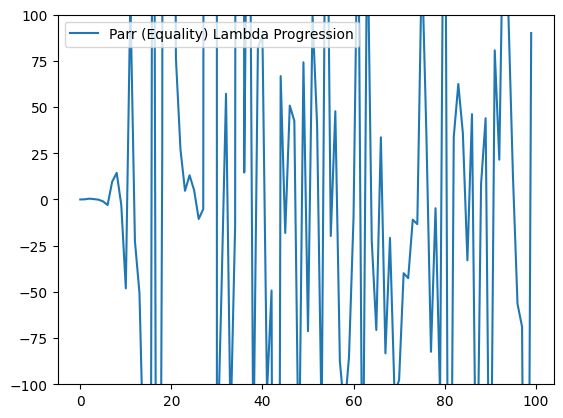

In [67]:
plt.plot(parr_lambda_progression, label="Parr (Equality) Lambda Progression")
plt.legend()
plt.ylim(-100, 100)
plt.show()

### Lagrange Multipliers (Batch Size = 3)

[]

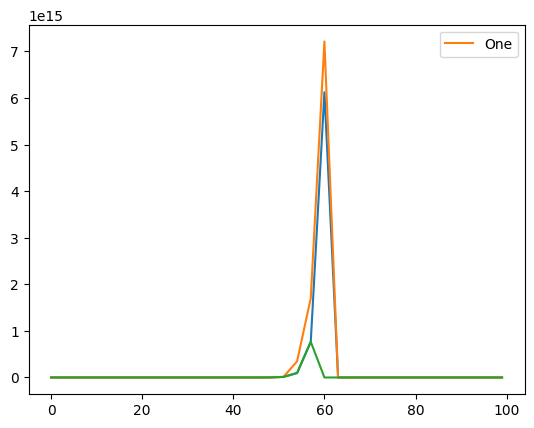

In [54]:
# Run 12 goes badly wrong
run = 5

with open(f"GBSP_batch_three/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)
a = tf.Variable(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])
inequality_lambda_vals = tf.transpose(tf.reshape(a, (34,3)))
x = np.arange(0, 102, 3)
plt.plot(x, inequality_lambda_vals[0])
plt.plot(x, inequality_lambda_vals[1], label="One")
plt.plot(x, inequality_lambda_vals[2])
plt.legend()
plt.plot()

[]

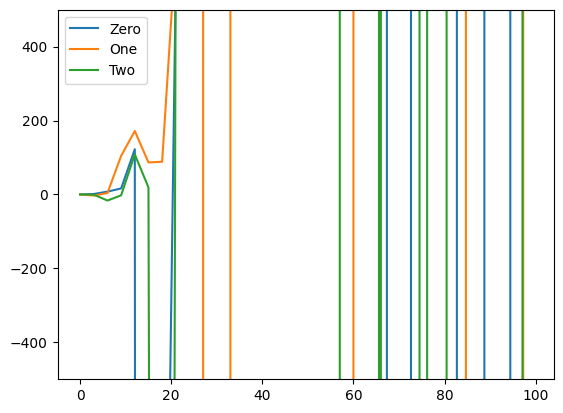

In [59]:
# Branin (equality) Lambda Progression
with open(f"GBSP_batch_three/run_{run}_equality_lambda_progression.pkl", "rb") as fp:
    equality_lambda = pickle.load(fp)
a = tf.Variable(equality_lambda[EQUALITY_CONSTRAINT_ONE])
centered_branin_lambda_vals = tf.transpose(tf.reshape(a, (34,3)))
plt.plot(x, centered_branin_lambda_vals[0], label="Zero")
plt.plot(x, centered_branin_lambda_vals[1], label="One")
plt.plot(x, centered_branin_lambda_vals[2], label="Two")
plt.ylim(-500, 500)
plt.legend()
plt.plot()

[]

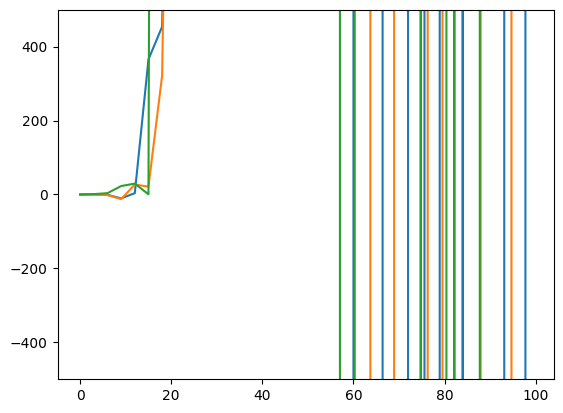

In [58]:
# Parr (equality) Lambda Progression
with open(f"GBSP_batch_three/run_{run}_equality_lambda_progression.pkl", "rb") as fp:
    equality_lambda = pickle.load(fp)
a = tf.Variable(equality_lambda[EQUALITY_CONSTRAINT_TWO])
parr_lambda_vals = tf.transpose(tf.reshape(a, (34,3)))
plt.plot(x, parr_lambda_vals[0])
plt.plot(x, parr_lambda_vals[1])
plt.plot(x, parr_lambda_vals[2])
plt.ylim(-500, 500)
plt.plot()


### Penalty Progression

In [44]:
run = 2

with open(f"GBSP_batch_one/run_{run}_penalty_progression.pkl", "rb") as fp:
    penalty_prog = pickle.load(fp)
penalty_prog = tf.transpose(tf.reshape(penalty_prog[1:], (33,3)))
penalty_prog

<tf.Tensor: shape=(3, 33), dtype=float64, numpy=
array([[4.63377590e+00, 5.79221988e-01, 7.24027485e-02, 9.05034356e-03,
        1.13129295e-03, 1.41411618e-04, 1.76764523e-05, 2.20955653e-06,
        1.10477827e-06, 1.10477827e-06, 1.38097283e-07, 1.38097283e-07,
        1.38097283e-07, 1.38097283e-07, 1.38097283e-07, 1.38097283e-07,
        1.38097283e-07, 1.38097283e-07, 1.38097283e-07, 1.38097283e-07,
        1.38097283e-07, 1.38097283e-07, 6.90486417e-08, 3.45243208e-08,
        3.45243208e-08, 3.45243208e-08, 3.45243208e-08, 3.45243208e-08,
        3.45243208e-08, 3.45243208e-08, 3.45243208e-08, 3.45243208e-08,
        3.45243208e-08],
       [2.31688795e+00, 2.89610994e-01, 3.62013743e-02, 4.52517178e-03,
        5.65646473e-04, 7.07058091e-05, 8.83822614e-06, 1.10477827e-06,
        1.10477827e-06, 5.52389134e-07, 1.38097283e-07, 1.38097283e-07,
        1.38097283e-07, 1.38097283e-07, 1.38097283e-07, 1.38097283e-07,
        1.38097283e-07, 1.38097283e-07, 1.38097283e-07, 1.3809

In [45]:
with open(f"GBSP_batch_three/run_{run}_penalty_progression.pkl", "rb") as fp:
    penalty_prog = pickle.load(fp)
penalty_prog = tf.transpose(tf.reshape(penalty_prog[1:], (33,3)))

In [46]:
penalty_prog

<tf.Tensor: shape=(3, 33), dtype=float64, numpy=
array([[9.80969894e+00, 1.22621237e+00, 1.53276546e-01, 1.91595682e-02,
        2.39494603e-03, 2.99368254e-04, 1.49684127e-04, 7.48420634e-05,
        3.74210317e-05, 3.74210317e-05, 3.74210317e-05, 3.74210317e-05,
        3.74210317e-05, 3.74210317e-05, 3.74210317e-05, 3.74210317e-05,
        3.74210317e-05, 3.74210317e-05, 3.74210317e-05, 3.74210317e-05,
        3.74210317e-05, 1.87105159e-05, 4.67762896e-06, 4.67762896e-06,
        4.67762896e-06, 2.33881448e-06, 5.84703620e-07, 5.84703620e-07,
        5.84703620e-07, 5.84703620e-07, 5.84703620e-07, 2.92351810e-07,
        1.46175905e-07],
       [9.80969894e+00, 1.22621237e+00, 1.53276546e-01, 1.91595682e-02,
        2.39494603e-03, 2.99368254e-04, 2.99368254e-04, 2.99368254e-04,
        2.99368254e-04, 2.99368254e-04, 2.99368254e-04, 2.99368254e-04,
        2.99368254e-04, 2.99368254e-04, 2.99368254e-04, 2.99368254e-04,
        2.99368254e-04, 2.99368254e-04, 2.99368254e-04, 2.9936